In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # cross_val_score ekledim
from sklearn.linear_model import Lasso
import math
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score 
from sklearn import linear_model
from sklearn import decomposition, datasets
from sklearn.linear_model import LassoCV
#from yellowbrick.datasets import load_concrete
#from yellowbrick.regressor import AlphaSelection
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
numberofProducts=300
numberofCluster=3

In [3]:
data_full = pd.read_csv("A.csv")
data = data_full[["product_id","sales", "price", "basket", "fav", "visit", "impression", "stock", "demand", "removeFromFav", "reviewCount", "rating"]]
data

,product_id,sales,price,basket,fav,visit,impression,stock,demand,removeFromFav,reviewCount,rating
0,207940697241116,2,119.00,11,0,81,0,48,0,0,0,0.0
1,207940697241116,5,119.00,19,0,124,0,43,0,4,0,0.0
2,207940697241116,8,119.00,34,0,224,0,35,0,5,0,0.0
3,207940697241116,18,119.00,61,0,379,980,17,0,6,0,0.0
4,207940697241116,17,119.00,81,0,509,1660,9992,0,10,2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
706900,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0
706901,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0
706902,2465458815060489,0,3.89,0,0,2,0,0,0,0,0,0.0
706903,2465458815060489,0,3.89,0,0,0,0,0,0,0,0,0.0


In [5]:
dateData = pd.read_csv("specialDates.csv")
for column in dateData.columns:
    data[column]=np.tile(dateData[column].to_numpy(),3415) 
data

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/341953613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column]=np.tile(dateData[column].to_numpy(),3415)


,product_id,sales,price,basket,fav,visit,impression,stock,demand,removeFromFav,reviewCount,rating,haftasonu,kampanya,resmitatil,ozelGun,Ozel3,Ozel5
0,207940697241116,2,119.00,11,0,81,0,48,0,0,0,0.0,0,0,0,0,0,0
1,207940697241116,5,119.00,19,0,124,0,43,0,4,0,0.0,0,0,0,0,0,0
2,207940697241116,8,119.00,34,0,224,0,35,0,5,0,0.0,1,0,0,0,0,0
3,207940697241116,18,119.00,61,0,379,980,17,0,6,0,0.0,1,0,0,0,0,0
4,207940697241116,17,119.00,81,0,509,1660,9992,0,10,2,5.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706900,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0
706901,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0
706902,2465458815060489,0,3.89,0,0,2,0,0,0,0,0,0.0,0,0,0,0,0,0
706903,2465458815060489,0,3.89,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0


In [6]:
# Returns logarithmic range between start power to end power
# Alternative to np.logspace(10e-5, 10, 100, endpoint=True)
def log_range(start,end):
    lst = []
    for i in range(start-end+1):
        power = start - i
        unit = 10**power
        for j in range(9):
            lst.append(unit*(j+1))
    return lst

In [7]:
alpha_search_range = log_range(2, -6)
def searching(X, y):
    ## en iyi alpha değer için araştırma yapıyor
    pipeline = Pipeline([
                         ('scaler',StandardScaler()),
                         ('model',Lasso())
        ])
    
    #Searching for best alpha
    search = GridSearchCV(pipeline,
                        {'model__alpha':alpha_search_range}, # burayı nasıl değiştireceğimi anlamadım tam
                        scoring="neg_mean_squared_error",verbose=0
                        )
    #fit model
    search.fit(X,y)
    coefficients = search.best_estimator_.named_steps['model'].coef_
    #print(search.best_estimator_,"AAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    return (search.best_estimator_.named_steps['model'].get_params()['alpha'], coefficients) 

In [8]:
def regression(metrics, X_train, y_train, X_test, y_test):
    productLasso = []
    for metric in metrics:
        alph= metric[0] # burada en uygun alpha değerine göre lasso yapıyor ve sonuçları alıyor 
        lasso= Lasso(alpha=alph)
        lasso.fit(X_train, y_train)
        y_train_pred= lasso.predict(X_train)
        y_test_pred= lasso.predict(X_test)
        productLasso.append((mean_absolute_percentage_error(y_train,y_train_pred), mean_absolute_percentage_error(y_test,y_test_pred)))
    return productLasso

In [9]:
def z_normal(col):
    if(np.std(col) == 0):
        return col
    return (col-np.mean(col))/np.std(col)

In [10]:
salesID=[]
for prodId in data["product_id"].unique():
    prodData=data[data.product_id==int(prodId)]
    salesID.append(np.mean(prodData['sales']))
    
len([i for i in salesID if i > 20])


45

In [52]:
def manipulation_and_search(data, max_lag = 7, num_prod = 50):
    boolTest=True
    metrics = []
    count = 0 ## kaç ürün için lasso yapılacak diye tutuldu
    prodsOfData=data["product_id"].unique()
    for j in range(len(prodsOfData)):
        
        prodData=data[data.product_id==int(prodsOfData[j])]
        saleAvg=np.mean(prodData['sales'])
        if saleAvg<20:
            continue
        
        prodIds.append(prodsOfData[j])
        count += 1
        prodData = data[207*j:207*(j+1)]   
        #Productlasso = {}
        #productLasso=[]
        for column in prodData.columns:
            if column in ['product_id','sales', 'price', 'haftasonu', 'kampanya', 'resmitatil', 'ozelGun', 'Ozel3', 'Ozel5']: continue
            for lag in range(1, max_lag+1):
                name = f"{column}({lag})"
                prodData[name] = prodData[column].shift(lag).copy()
                """
                alphas = np.logspace(-10, 1, 400)
                # Instantiate the linear model and visualizer
                model = LassoCV(alphas=alphas)
                visualizer = AlphaSelection(model)
                visualizer.fit(X, y)
                visualizer.show()
                """
        X=prodData.iloc[max_lag:, 2:]
        X.drop(["basket", "fav", "visit", "impression", "stock", "demand", "removeFromFav", "reviewCount", "rating"], axis =1, inplace = True)
        if count == 1 : 
            global col_names 
            col_names = X.columns # get column names
        y = prodData["sales"][max_lag:]
        # buradaki X_test ve y_test sonradan kullanılabilir şekilde değil, 
        X_train, X_test = np.split(X, [int(.8*len(X))])
        y_train, y_test = np.split(y, [int(.8*len(y))])
        
        # data for dynamic regression
        X=pd.concat([X_train, X_test], ignore_index=True)
        Y=pd.concat([pd.DataFrame(y_train,columns=['sales']), pd.DataFrame(y_test,columns=['sales'])], ignore_index=True)
        X.insert(0, 'product_id', f"{prodsOfData[j]}")
        Y.insert(0, 'product_id', f"{prodsOfData[j]}")
        if boolTest:
            Xs=X
            Ys=Y
            boolTest=False
        else:
            Xs=pd.concat([Xs, X], ignore_index=True)
            Ys=pd.concat([Ys, Y], ignore_index=True)
        #normalize
        for name in X_train.columns:
            X_train[name] = z_normal(X_train[name].copy())
            X_test[name] = z_normal(X_test[name].copy())
        y_train = z_normal(y_train.copy())
        y_test = z_normal(y_test.copy())
        
            
        
        results = searching(X_train, y_train)
        metrics.append(results)
        
        if count == num_prod: # burada ürün sayısı belirtilecek
            break        
    
        
    return metrics, X_train, y_train, X_test, y_test, Xs, Ys

In [53]:
col_names = []
prodIds=[]
Xs=[]
Ys=[]
import time
start = time.perf_counter()
metrics, X_train, y_train, X_test, y_test, Xs, Ys = manipulation_and_search(data)
end = time.perf_counter()
print("It took ", (end-start)/60)

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-01, tolerance: 1.198e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.220e-02, tolerance: 1.338e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+01, tolerance: 1.198e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+01, tolerance: 1.198e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.659e+00, tolerance: 1.338e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e+01, tolerance: 1.198e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+01, tolerance: 1.338e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e-02, tolerance: 2.495e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.344e-01, tolerance: 1.431e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.661e-01, tolerance: 1.493e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+00, tolerance: 1.541e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+00, tolerance: 1.541e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+00, tolerance: 2.495e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e+00, tolerance: 1.431e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e+00, tolerance: 1.486e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.686e+00, tolerance: 1.493e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+00, tolerance: 1.541e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-01, tolerance: 4.084e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.305e-01, tolerance: 1.403e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.683e+00, tolerance: 1.403e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+00, tolerance: 1.420e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.832e+00, tolerance: 1.565e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+00, tolerance: 1.430e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e+00, tolerance: 1.403e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e+00, tolerance: 1.420e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.150e-01, tolerance: 1.467e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e-01, tolerance: 2.095e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+00, tolerance: 2.095e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+00, tolerance: 1.540e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.313e+00, tolerance: 1.485e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.933e+00, tolerance: 1.467e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+00, tolerance: 1.540e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.476e+00, tolerance: 1.527e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e+00, tolerance: 1.505e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.065e-01, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e+00, tolerance: 1.505e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+00, tolerance: 1.511e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.339e-01, tolerance: 9.665e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+00, tolerance: 1.511e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e+00, tolerance: 7.914e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+00, tolerance: 1.433e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 7.914e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.433e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.208e-01, tolerance: 1.514e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.489e-01, tolerance: 1.322e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+00, tolerance: 1.198e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.127e+00, tolerance: 7.914e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-02, tolerance: 1.381e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e-02, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.434e-02, tolerance: 1.381e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.500e-02, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.441e+00, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.684e-01, tolerance: 1.399e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+01, tolerance: 1.381e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e+01, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.910e+00, tolerance: 1.549e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.535e+00, tolerance: 1.468e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e+00, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.282e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.302e+00, tolerance: 1.549e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.290e+00, tolerance: 1.468e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.785e+00, tolerance: 1.468e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.108e+01, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.266e-01, tolerance: 1.264e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.639e-01, tolerance: 8.650e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+00, tolerance: 1.583e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.480e+00, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e+00, tolerance: 1.583e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+00, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.581e-02, tolerance: 1.120e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+00, tolerance: 1.394e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.710e+00, tolerance: 1.120e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.044e+00, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.307e+00, tolerance: 1.394e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.340e+00, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.964e+00, tolerance: 1.394e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.635e+00, tolerance: 9.969e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.072e+00, tolerance: 1.403e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e-01, tolerance: 1.371e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e+00, tolerance: 1.096e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.233e+00, tolerance: 1.096e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.270e-01, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.433e+00, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.146e+01, tolerance: 1.371e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e-02, tolerance: 3.557e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-02, tolerance: 1.402e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e+00, tolerance: 1.528e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-01, tolerance: 3.557e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.814e-01, tolerance: 3.557e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.578e+00, tolerance: 1.402e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.638e+00, tolerance: 1.528e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+00, tolerance: 3.557e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.713e-01, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e-01, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e+00, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.259e+00, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e+01, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+01, tolerance: 1.400e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e-01, tolerance: 7.977e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+01, tolerance: 1.182e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.409e-01, tolerance: 7.977e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+01, tolerance: 1.182e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 1.225e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.856e-01, tolerance: 6.077e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e+00, tolerance: 1.225e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+00, tolerance: 6.077e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+00, tolerance: 1.527e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.728e+00, tolerance: 1.298e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e-01, tolerance: 1.007e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.492e-01, tolerance: 1.455e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+00, tolerance: 1.455e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.993e-01, tolerance: 8.852e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.440e+00, tolerance: 1.455e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e+00, tolerance: 8.852e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.861e+00, tolerance: 1.455e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.917e+00, tolerance: 1.381e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.580e-01, tolerance: 5.968e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.209e-01, tolerance: 1.254e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.167e-01, tolerance: 5.968e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+00, tolerance: 1.254e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.962e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.810e+00, tolerance: 1.397e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e+00, tolerance: 1.383e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e+00, tolerance: 5.968e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.949e+00, tolerance: 1.397e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.195e+00, tolerance: 1.383e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.072e-02, tolerance: 1.092e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.047e-01, tolerance: 1.358e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.614e+00, tolerance: 1.092e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.507e+00, tolerance: 1.358e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.550e+00, tolerance: 1.134e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.427e+00, tolerance: 1.092e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.119e-01, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.996e-02, tolerance: 1.145e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.270e+00, tolerance: 1.484e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-01, tolerance: 1.145e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.399e-01, tolerance: 5.813e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.471e+00, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.312e-01, tolerance: 1.145e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e+00, tolerance: 1.572e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.527e+00, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+00, tolerance: 1.544e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-03, tolerance: 1.989e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.400e+00, tolerance: 1.434e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.949e+00, tolerance: 1.544e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.049e+00, tolerance: 1.513e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.007e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-02, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-02, tolerance: 5.959e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.367e+00, tolerance: 1.305e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.508e-01, tolerance: 1.305e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.881e-01, tolerance: 1.341e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.850e+00, tolerance: 1.523e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e+00, tolerance: 1.480e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.406e+00, tolerance: 1.375e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.618e+00, tolerance: 1.420e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e-02, tolerance: 7.193e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e+00, tolerance: 1.375e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.333e-01, tolerance: 7.193e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e+00, tolerance: 1.375e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.153e+00, tolerance: 1.394e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+00, tolerance: 7.193e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.521e-01, tolerance: 1.258e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e+00, tolerance: 1.373e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.311e-01, tolerance: 9.729e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.983e-02, tolerance: 1.278e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.631e+00, tolerance: 1.373e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.174e+00, tolerance: 1.410e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.020e+01, tolerance: 1.410e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.287e+00, tolerance: 9.729e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.731e+00, tolerance: 1.278e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.930e+00, tolerance: 1.258e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e+00, tolerance: 1.385e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.998e-02, tolerance: 7.549e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.890e+00, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+00, tolerance: 1.192e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.878e+00, tolerance: 1.366e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.412e+00, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.227e+00, tolerance: 1.385e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.272e-02, tolerance: 1.397e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.852e+00, tolerance: 1.419e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.150e+00, tolerance: 1.397e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.512e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.322e-01, tolerance: 6.160e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.513e+00, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.646e+00, tolerance: 1.531e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.171e+00, tolerance: 1.512e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.010e+00, tolerance: 6.160e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.977e+00, tolerance: 1.465e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+00, tolerance: 1.531e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+00, tolerance: 6.048e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.777e-01, tolerance: 1.437e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.959e+00, tolerance: 1.284e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e+00, tolerance: 6.048e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e+00, tolerance: 6.048e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e+00, tolerance: 1.437e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e-01, tolerance: 1.488e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.366e-02, tolerance: 6.936e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e+00, tolerance: 1.564e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e-01, tolerance: 1.488e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.409e+00, tolerance: 1.521e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.375e+00, tolerance: 1.075e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.587e+00, tolerance: 1.488e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+00, tolerance: 6.936e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e+00, tolerance: 6.936e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.538e+00, tolerance: 1.521e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e-03, tolerance: 2.683e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+00, tolerance: 1.369e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e-01, tolerance: 2.683e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.161e+00, tolerance: 1.369e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.006e+00, tolerance: 1.510e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.864e+00, tolerance: 1.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.354e-01, tolerance: 2.683e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e-02, tolerance: 1.518e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e-02, tolerance: 1.162e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.811e+00, tolerance: 1.518e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+00, tolerance: 5.332e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.307e+00, tolerance: 1.562e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.757e+00, tolerance: 1.558e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.266e+00, tolerance: 1.562e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.857e+00, tolerance: 1.558e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.642e-02, tolerance: 1.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e-02, tolerance: 1.545e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e-02, tolerance: 1.545e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.876e-02, tolerance: 1.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e+00, tolerance: 1.545e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.508e-01, tolerance: 1.330e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.671e-02, tolerance: 3.431e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e+00, tolerance: 1.330e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.853e-02, tolerance: 7.577e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.826e-02, tolerance: 1.441e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.967e-02, tolerance: 7.577e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.129e-02, tolerance: 1.441e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e+00, tolerance: 7.577e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e+00, tolerance: 1.441e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+00, tolerance: 9.847e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+00, tolerance: 1.077e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e-01, tolerance: 9.847e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-01, tolerance: 1.077e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+00, tolerance: 1.077e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+00, tolerance: 1.527e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e+00, tolerance: 9.847e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+00, tolerance: 1.077e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+00, tolerance: 7.102e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.770e-02, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e+00, tolerance: 1.559e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e+00, tolerance: 1.498e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+00, tolerance: 1.559e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e+00, tolerance: 1.498e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.171e+00, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+00, tolerance: 1.559e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+00, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e+00, tolerance: 1.559e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.539e+00, tolerance: 1.370e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e-02, tolerance: 1.534e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e-02, tolerance: 1.534e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.546e+00, tolerance: 1.534e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.960e-01, tolerance: 1.588e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-03, tolerance: 5.022e-04
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.001e+00, tolerance: 1.534e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-02, tolerance: 1.588e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.069e-04, tolerance: 5.022e-04
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-01, tolerance: 1.536e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e-01, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-02, tolerance: 1.518e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e-01, tolerance: 1.536e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+00, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+00, tolerance: 1.500e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+00, tolerance: 1.526e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.011e-01, tolerance: 1.518e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+00, tolerance: 1.536e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+00, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+01, tolerance: 1.421e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.238e+00, tolerance: 1.205e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e-01, tolerance: 1.205e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+00, tolerance: 1.318e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+01, tolerance: 1.205e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.923e+00, tolerance: 1.318e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e+01, tolerance: 1.421e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+01, tolerance: 1.205e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e-01, tolerance: 1.502e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-01, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.940e-01, tolerance: 1.538e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.309e-01, tolerance: 1.502e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.356e-01, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.242e-01, tolerance: 1.513e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.508e-01, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.698e-01, tolerance: 1.513e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.649e-01, tolerance: 1.502e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.471e-01, tolerance: 1.520e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.949e-02, tolerance: 1.573e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.614e-02, tolerance: 1.547e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e-02, tolerance: 1.128e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.679e-01, tolerance: 1.573e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.698e-01, tolerance: 1.573e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+00, tolerance: 1.547e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.104e+00, tolerance: 1.547e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+00, tolerance: 1.461e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+00, tolerance: 1.461e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+00, tolerance: 1.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e-02, tolerance: 1.464e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.904e-01, tolerance: 1.470e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e+00, tolerance: 1.049e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e+00, tolerance: 7.843e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e+00, tolerance: 7.843e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.616e+00, tolerance: 1.488e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+00, tolerance: 1.488e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e+00, tolerance: 1.464e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.029e-01, tolerance: 6.398e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e-01, tolerance: 1.440e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e+00, tolerance: 1.196e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e+00, tolerance: 6.398e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.779e+00, tolerance: 1.440e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e+00, tolerance: 1.461e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.297e+00, tolerance: 1.433e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.664e+00, tolerance: 1.196e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.672e-01, tolerance: 1.525e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.862e-01, tolerance: 1.524e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-02, tolerance: 1.284e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.362e+00, tolerance: 1.560e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.751e-01, tolerance: 1.284e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.843e+00, tolerance: 1.560e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.594e+00, tolerance: 1.545e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.373e+00, tolerance: 1.525e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.691e-01, tolerance: 1.158e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e+00, tolerance: 1.223e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+00, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.358e+00, tolerance: 1.158e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.733e+00, tolerance: 1.211e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.223e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.144e+01, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+01, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.148e+00, tolerance: 1.158e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 4.413e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+00, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e+00, tolerance: 1.288e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.996e+00, tolerance: 1.475e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.958e+00, tolerance: 1.473e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.069e+00, tolerance: 1.424e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\Users\BERKAY~1\AppData\Local\Temp/ipykernel_22824/1601493887.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag).copy()
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.905e-02, tolerance: 8.377e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e-01, tolerance: 1.424e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e-02, tolerance: 1.235e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e-02, tolerance: 1.394e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.799e+00, tolerance: 8.377e-03
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e+01, tolerance: 1.235e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+01, tolerance: 1.425e-02
  model = cd_fast.enet_coordinate_descent(
c:\users\berkay akbulut\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

It took  2.1725727833333357


In [38]:
#metrics

In [ ]:
maeA=[]
mapeA=[]
for i in range(numberofProducts):
    
    params = metrics[i][1]
    tst = X_test[i].to_numpy()
    prediction = tst.dot(np.array(params))
    mae = mean_absolute_error(y_test[i], prediction)
    mape = mean_absolute_percentage_error(y_test[i], prediction)
    nzero_index = np.nonzero(params)[0]
    param_names = col_names[nzero_index]
    #print(param_names,mae,mape)
    maeA.append(mae)
    mapeA.append(mape)

    #print(prediction-y_test, y_test)

In [26]:
#metric extraction
coefficients = []
index=0
#prods=data["product_id"].unique()
#prodIds
for metric in metrics:
    Precoeffs= metric[1]
    prodID=prodIds[index]
    Postcoeffs=[f"{prodID}"]
    for Precoeff in Precoeffs:
        if Precoeff!=0.0:
            Postcoeffs.append(1.0)
        else:
            Postcoeffs.append(0.0)
    coefficients.append(Postcoeffs)
    index+=1
coeff2 = coefficients[:]


In [27]:
coeff3=[]
prodsID=[]
for co in coeff2:
    coeff3.append(co[1:])
    prodsID.append(co[0])
coeff3



[[1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.

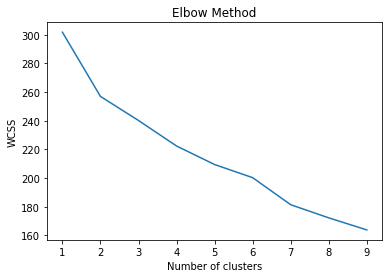

In [28]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    # coeff2 2D array bekliyor 
    kmeans.fit(coeff3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=numberofCluster, init='k-means++', max_iter=300, n_init=20, random_state=0)
pred_y = kmeans.fit_predict(coeff2)
"""
plt.scatter(np.array(coeff2)[:, 1], np.array(coeff2)[:, -1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()
"""

"\nplt.scatter(np.array(coeff2)[:, 1], np.array(coeff2)[:, -1])\nplt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')\nplt.show()\n"

In [30]:
kmeans.cluster_centers_

array([[ 3.96934336e+15,  3.15789474e-01,  2.63157895e-01,
         2.63157895e-01,  4.21052632e-01,  5.26315789e-02,
         1.57894737e-01,  1.05263158e-01,  1.00000000e+00,
         1.57894737e-01,  1.57894737e-01,  1.05263158e-01,
         2.10526316e-01,  1.57894737e-01,  5.26315789e-02,
         1.57894737e-01,  2.10526316e-01,  5.26315789e-02,
         1.57894737e-01,  2.10526316e-01,  1.57894737e-01,
         1.57894737e-01,  5.26315789e-02,  5.26315789e-02,
         2.08166817e-17,  5.26315789e-02,  5.26315789e-02,
         5.26315789e-02,  1.57894737e-01,  1.05263158e-01,
         3.15789474e-01,  2.10526316e-01,  2.10526316e-01,
         2.63157895e-01,  1.05263158e-01,  1.57894737e-01,
         2.10526316e-01,  1.05263158e-01,  1.05263158e-01,
         5.26315789e-02,  5.26315789e-02,  5.26315789e-02,
         1.57894737e-01,  2.63157895e-01,  1.57894737e-01,
         2.63157895e-01,  5.26315789e-02,  2.10526316e-01,
         2.63157895e-01,  2.10526316e-01,  3.15789474e-0

In [31]:
# buradan hangi ürün hangi clustera konulmuş anlaşılıyor
kmeans.labels_

array([1, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 2, 1,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0,
       1])

In [ ]:
"""
produt_ids=data["product_id"].unique()[:10]
produt_ids=np.char.mod('%d', produt_ids)
clusterLabels=kmeans.labels_
produt_ids=np.array(produt_ids)
clusterLabels=np.array(clusterLabels)
maeA=np.array(maeA)
mapeA=np.array(mapeA)
lis=np.array([produt_ids, clusterLabels, maeA, mapeA])
outputDF=pd.DataFrame(data = np.transpose(lis), columns=['product_id','label','mae','mape'])
outputDF
"""

In [ ]:
"""
salesID=[]
for prodId in prodsID:
    prodData=data[data.product_id==int(prodId)]
    salesID.append(np.mean(prodData['sales']))
    
len([i for i in salesID if i > 10])
"""

In [48]:
prod=['product_id']
names=np.concatenate((prod, col_names))
coefDF=pd.DataFrame(data = coeff2,columns=names)
coefDF

,product_id,price,haftasonu,kampanya,resmitatil,ozelGun,Ozel3,Ozel5,basket(1),basket(2),...,reviewCount(5),reviewCount(6),reviewCount(7),rating(1),rating(2),rating(3),rating(4),rating(5),rating(6),rating(7)
0,207940697241116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4445491431117742,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2765821603728117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2723917323057815,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,3271492011497598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3460908783287409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3281544603178675,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,794983244043667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2845447291779888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,552773233652610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
Xs

,product_id,price,haftasonu,kampanya,resmitatil,ozelGun,Ozel3,Ozel5,basket(1),basket(2),...,reviewCount(5),reviewCount(6),reviewCount(7),rating(1),rating(2),rating(3),rating(4),rating(5),rating(6),rating(7)
0,207940697241116,99.0,0,0,0,0,0,0,77.0,70.0,...,0.0,0.0,0.0,5.0,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000
1,207940697241116,99.0,0,0,0,0,0,0,96.0,77.0,...,0.0,0.0,0.0,4.2,5.000000,1.000000,5.000000,0.000000,0.000000,0.000000
2,207940697241116,99.0,1,0,0,0,0,0,97.0,96.0,...,2.0,0.0,0.0,5.0,4.200000,5.000000,1.000000,5.000000,0.000000,0.000000
3,207940697241116,79.0,1,0,0,0,0,0,160.0,97.0,...,1.0,2.0,0.0,4.0,5.000000,4.200000,5.000000,1.000000,5.000000,0.000000
4,207940697241116,59.0,0,0,0,0,0,0,256.0,160.0,...,2.0,1.0,2.0,5.0,4.000000,5.000000,4.200000,5.000000,1.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1011252778676425,9.3,0,0,0,0,0,0,211.0,227.0,...,1.0,9.0,5.0,5.0,4.555556,4.750000,3.750000,5.000000,4.555556,4.600000
8996,1011252778676425,9.3,0,0,0,0,0,0,168.0,211.0,...,4.0,1.0,9.0,5.0,5.000000,4.555556,4.750000,3.750000,5.000000,4.555556
8997,1011252778676425,9.3,0,0,0,0,0,0,144.0,168.0,...,8.0,4.0,1.0,5.0,5.000000,5.000000,4.555556,4.750000,3.750000,5.000000
8998,1011252778676425,9.3,1,0,0,0,0,0,144.0,144.0,...,9.0,8.0,4.0,5.0,5.000000,5.000000,5.000000,4.555556,4.750000,3.750000


In [55]:
Ys

,product_id,sales
0,207940697241116,20
1,207940697241116,24
2,207940697241116,47
3,207940697241116,85
4,207940697241116,568
...,...,...
8995,1011252778676425,68
8996,1011252778676425,68
8997,1011252778676425,64
8998,1011252778676425,32


In [57]:
filename="A-Lasso45.csv"
coefDF.to_csv(filename, sep=',',header=True, index = False)
fileX="A-LassoX.csv"
Xs.to_csv(fileX, sep=',',header=True, index = False)
fileY="A-LassoY.csv"
Ys.to_csv(fileY, sep=',',header=True, index = False)

In [ ]:
# en son bu şekilde basılabilir istedğimiz buysa. 
filename="A-LassoCluster.csv"
outputDF.to_csv(filename, sep=',',header=True)

In [ ]:
"""
reg_res = regression(metrics, X_train, y_train, X_test, y_test)
print(reg_res)
sum = 0
for reg in reg_res:
    sum += reg[1]
sum / len(reg_res)
"""

In [ ]:
"""
labels = ["trainMAE","testMAE","price", "basket", "fav", "visit", "impression", "stock", "demand", "removeFromFav", "reviewCount", "rating","haftasonu","kampanya","resmitatil","ozelGun","Ozel3","Ozel5"]
WholeLasso=lasso(data)
WholeLasso=pd.DataFrame(WholeLasso, columns=labels)
WholeLasso
"""

In [ ]:
"""
filename="A-Lasso.csv"
WholeLasso.to_csv(filename, sep=',',header=True)
"""